#### Gather Experiment

In [370]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd

# Must match with training file train.py
mlflow.set_tracking_uri("http://localhost:" + "32770")
client: MlflowClient = MlflowClient()
experiment = client.get_experiment_by_name("CF_r1.0_0.5_0.1_e50_b1024_v3")

runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
print(f"Found {len(runs)} runs")
print(runs.columns)

Found 18 runs
Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.recall', 'metrics.precision', 'metrics.accuracy',
       'metrics.f1_score', 'metrics.train_loss', 'metrics.val_f1',
       'metrics.val_loss', 'params.batch_size', 'params.epochs',
       'params.num_majority', 'params.loss_function', 'params.learning_rate',
       'params.num_layers', 'params.imbalance_ratio', 'params.subsample_ratio',
       'params.gamma', 'params.hidden_size', 'params.num_minority',
       'params.alpha', 'params.loss_params', 'params.ce_weight',
       'tags.mlflow.source.git.commit', 'tags.mlflow.source.name',
       'tags.mlflow.runName', 'tags.mlflow.source.type', 'tags.mlflow.user'],
      dtype='object')


In [371]:
#print(runs.describe())

#### Get all results

In [372]:
all_results = []

# Iterate through all runs, not just the best
for idx, row in runs.iterrows():
    loss_fn = row['params.loss_function']

    result = {
        'imbalance_ratio': row['params.imbalance_ratio'],
        'loss_fn': loss_fn,
        'f1_score': row['metrics.f1_score'],
        'run_id': row['run_id']
    }

    # Include loss-specific parameters
    if loss_fn == 'focal':
        result['alpha'] = row['params.alpha']
        result['gamma'] = row['params.gamma']
    elif loss_fn == 'wce':
        result['weight'] = row['params.ce_weight']

    # Add all metrics
    metrics_cols = [col for col in row.index if col.startswith('metrics.')]
    for metric_col in metrics_cols:
        metric_name = metric_col.replace('metrics.', '')
        result[metric_name] = row[metric_col]

    all_results.append(result)

results_df = pd.DataFrame(all_results)

# Create a combined label for variants
def loss_variant_label(row):
    if row['loss_fn'] == 'focal':
        return f"focal (α={row['alpha']}, γ={row['gamma']})"
    elif row['loss_fn'] == 'wce':
        return f"wce (weight={row['weight']})"
    else:
        return row['loss_fn']

results_df['loss_variant'] = results_df.apply(loss_variant_label, axis=1)

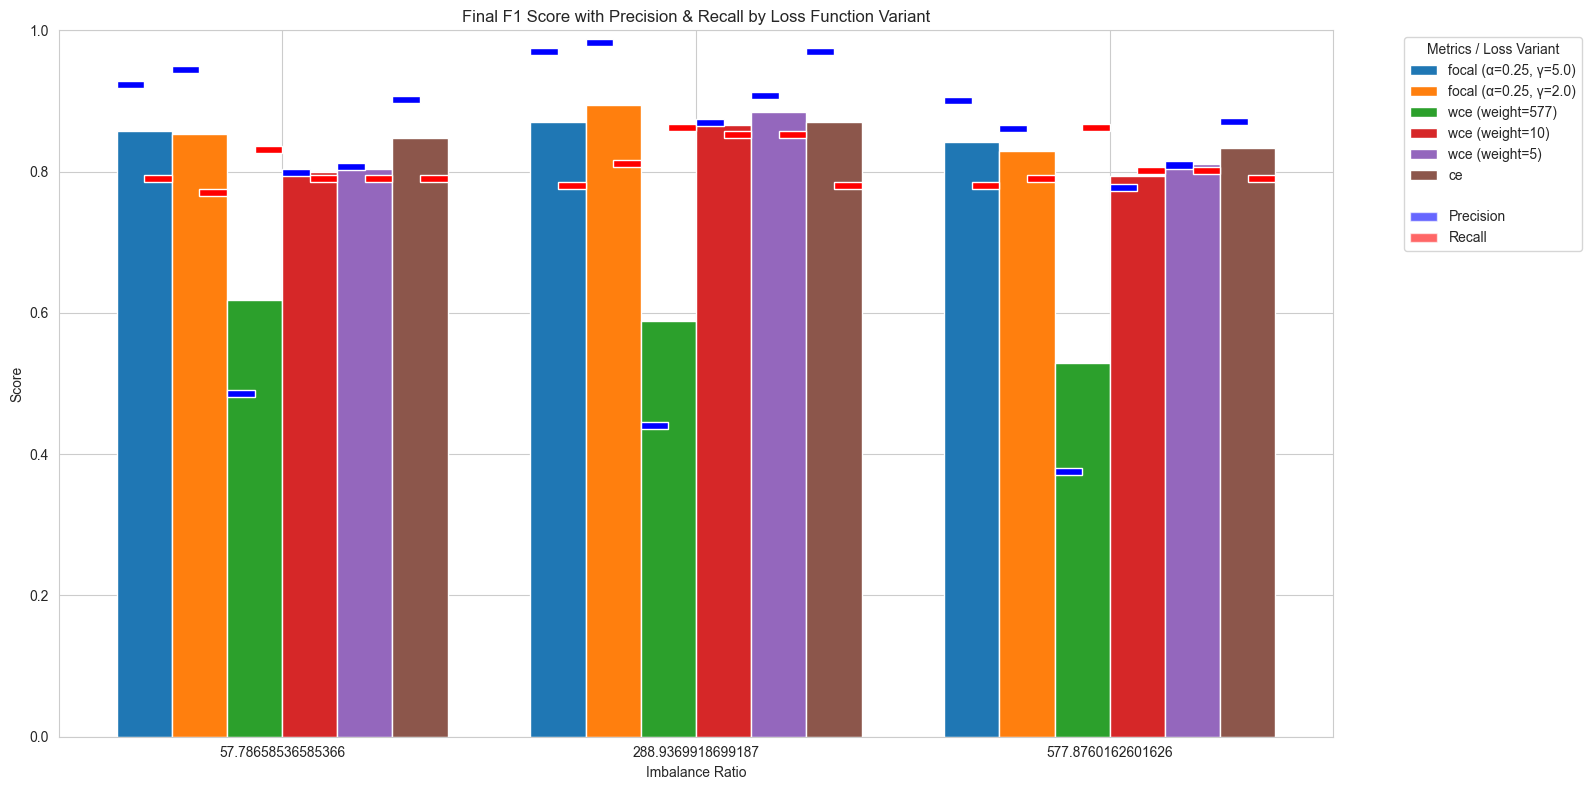

In [373]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)

x_labels = results_df['imbalance_ratio'].unique()
loss_variants = results_df['loss_variant'].unique()
metrics = ['precision', 'recall']

n_lv = len(loss_variants)
n_groups = len(x_labels)
group_width = 0.8
bar_width_f1 = (group_width / n_lv)
bar_width_metric = bar_width_f1 / 2
tip_height = 0.01

x = np.arange(n_groups)

# Assign colors to loss variants for F1 bars
palette = sns.color_palette("tab10", n_lv)
lv_colors = dict(zip(loss_variants, palette))

plt.figure(figsize=(16, 8))

for i, lv in enumerate(loss_variants):
    subset = results_df[results_df['loss_variant'] == lv].sort_values('imbalance_ratio')

    xpos_base = x - group_width/2 + i*bar_width_f1 + bar_width_f1/2
    xpos_f1 = x - group_width/2 + i*bar_width_f1 + bar_width_f1/2

    # Plot full F1 bar behind
    plt.bar(
        xpos_base,
        subset['f1_score'],
        width=bar_width_f1,
        color=lv_colors[lv],
        zorder=1
    )

    # Plot floating tips for Precision & Recall in front
    for j, metric in enumerate(metrics):
        xpos_metric = xpos_base - bar_width_metric/2 + j*bar_width_metric
        plt.bar(
            xpos_metric,
            tip_height,
            bottom=subset[metric] - tip_height,  # only top segment
            width=bar_width_metric,
            color='blue' if metric=='precision' else 'red',
            alpha=1,
            zorder=2
        )

# Set x-ticks
plt.xticks(x, [str(val) for val in x_labels])
plt.ylim(0, 1)
plt.title('Final F1 Score with Precision & Recall by Loss Function Variant')
plt.ylabel('Score')
plt.xlabel('Imbalance Ratio')

# Custom legend
legend_elements = [Patch(facecolor=color, label=lv) for lv, color in lv_colors.items()]
legend_elements += [Patch(facecolor='none', edgecolor='none', label='')]
legend_elements += [Patch(facecolor='blue', alpha=0.6, label='Precision'),
                    Patch(facecolor='red', alpha=0.6, label='Recall')]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title='Metrics / Loss Variant')

plt.tight_layout()
plt.show()


In [374]:
def fetch_all_val_f1_history(all_runs: pd.DataFrame, num_layers: int) -> pd.DataFrame:
    rows = []

    # Filter by number of layers
    df = all_runs[all_runs['params.num_layers'].astype(int) == num_layers]

    for _, row in df.iterrows():
        run_id = row['run_id']
        hist = client.get_metric_history(run_id, "val_f1")

        # Build a label for the loss configuration
        loss_config = row['params.loss_function']
        if 'params.alpha' in row and row['params.alpha'] is not None:
            loss_config += f"_alpha={row['params.alpha']}"
        if 'params.gamma' in row and row['params.gamma'] is not None:
            loss_config += f"_gamma={row['params.gamma']}"
        if 'params.ce_weight' in row and row['params.ce_weight'] is not None:
            loss_config += f"_ce={row['params.ce_weight']}"

        for m in hist:
            rows.append({
                "step": m.step,
                "val_f1": m.value,
                "imbalance_ratio": float(row['params.imbalance_ratio']),
                "loss_config": loss_config,
                "num_layers": num_layers,
                "run_id": run_id
            })

    return pd.DataFrame(rows)

In [375]:
def plot_convergence_grid_all(hist_df: pd.DataFrame, num_layer: int):
    if hist_df.empty:
        print(f"No history found for {num_layer} layers")
        return

    df = hist_df.copy()

    # Use imbalance ratio for facet labeling
    df['config'] = df.apply(lambda r: f"imb={r['imbalance_ratio']:.2f}", axis=1)

    g = sns.relplot(
        data=df,
        x="step",
        y="val_f1",
        hue="loss_config",
        kind="line",
        col="config",
        col_wrap=4,
        height=3,
        facet_kws={"sharex": True, "sharey": True},
        linewidth=1
    )
    g.set_axis_labels("Epoch", "Validation F1")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"val_f1 Convergence)")
    plt.show()

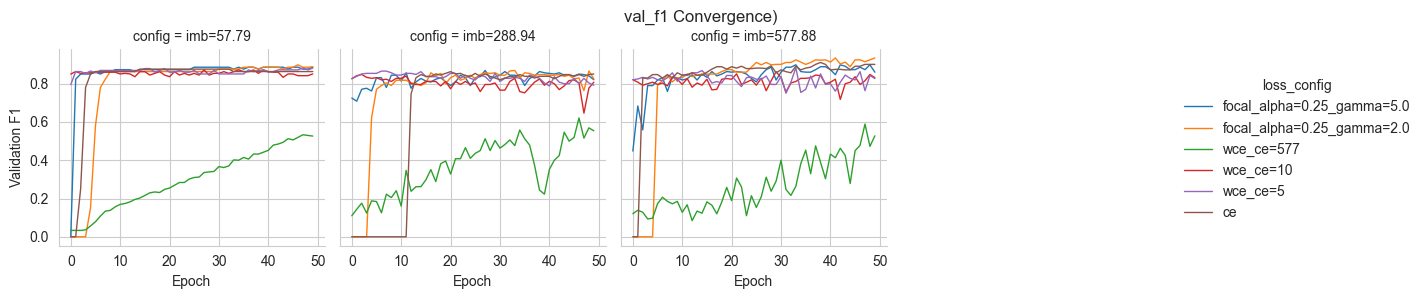

In [376]:
hist_small_all = fetch_all_val_f1_history(runs, num_layers=2)

plot_convergence_grid_all(hist_small_all, 2)

#### Plot F1 Convergence for the best scores

,run_id,imbalance_ratio,loss_function,metrics.val_f1
0,a515ea7dbad54778aa449d76d3b8f7e1,57.786585,ce,0.863636
1,848046275202474e9734b1b603ef072b,57.786585,focal,0.888889
2,999d0edb845c4d73899ee58ce64906bc,57.786585,wce,0.881720
3,e2e40a5a28a3468d94674e3c3c6a6e5d,288.936992,ce,0.851064
4,52a5763423d7442ebd31e8e03e6d68be,288.936992,focal,0.826087
5,49fa4ac9c2cf4643a98e76c7f511f16b,288.936992,wce,0.808081
6,252c70c83bba4c41a83f3c926b721006,577.876016,ce,0.901099
7,a157c0bfb50a4d519e7f42b5f8ed9141,577.876016,focal,0.934783
8,b9398de37f684915b1431246cb88455d,577.876016,wce,0.831683


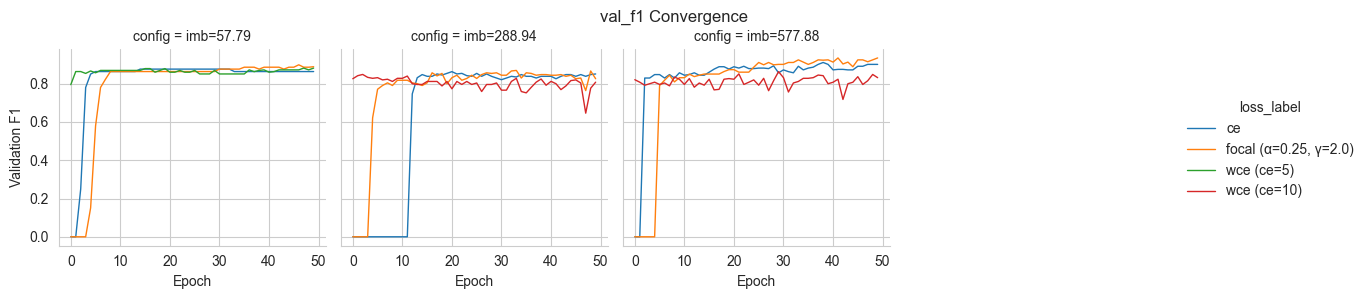

In [380]:
# Plot convergence based on the best scores


def get_best_runs_per_config(all_runs: pd.DataFrame, num_layers: int) -> pd.DataFrame:
    df = all_runs.copy()

    # Filter by number of layers
    df = df[df['params.num_layers'].astype(int) == num_layers]

    df['imbalance_ratio'] = df['params.imbalance_ratio'].astype(float)
    df['loss_function'] = df['params.loss_function']

    # Extract extra loss parameters safely → may or may not exist
    df['alpha'] = df.get('params.alpha', None)
    df['gamma'] = df.get('params.gamma', None)
    df['ce_weight'] = df.get('params.ce_weight', None)

    # Group by imbalance ratio and loss function
    best_idx = df.groupby(['imbalance_ratio', 'loss_function'])['metrics.val_f1'].idxmax()
    best = df.loc[best_idx].reset_index(drop=True)

    return best

def build_loss_label(row):
    name = row['loss_function']
    parts = []

    if pd.notna(row.get('alpha')):
        parts.append(f"α={row['alpha']}")
    if pd.notna(row.get('gamma')):
        parts.append(f"γ={row['gamma']}")
    if pd.notna(row.get('ce_weight')):
        parts.append(f"ce={row['ce_weight']}")

    if parts:
        return f"{name} ({', '.join(parts)})"
    else:
        return name



best = get_best_runs_per_config(runs, num_layers=2)
display(best[['run_id', 'imbalance_ratio', 'loss_function', 'metrics.val_f1']])

client = MlflowClient()

def fetch_val_f1_history(best_df: pd.DataFrame, num_layer: int) -> pd.DataFrame:
    rows = []

    for _, row in best_df.iterrows():
        run_id = row['run_id']

        # Build readable label
        detailed_label = build_loss_label(row)

        hist = client.get_metric_history(run_id, "val_f1")
        for m in hist:
            rows.append({
                "step": m.step,
                "val_f1": m.value,
                "imbalance_ratio": float(row['imbalance_ratio']),
                "loss_label": detailed_label,   # <-- HERE
                "num_layer": num_layer,
            })

    return pd.DataFrame(rows)


hist_small = fetch_val_f1_history(best, 2)


def plot_convergence_grid(hist_df: pd.DataFrame, num_layer: int):
    if hist_df.empty:
        print(f"No history found for {num_layer} layers")
        return

    df = hist_df.copy()
    df['config'] = df.apply(lambda r: f"imb={r['imbalance_ratio']:.2f}", axis=1)

    g = sns.relplot(
        data=df,
        x="step",
        y="val_f1",
        hue="loss_label",    # <-- use detailed labels
        kind="line",
        col="config",
        col_wrap=4,
        height=3,
        facet_kws={"sharex": True, "sharey": True},
        linewidth=1
    )
    g.set_axis_labels("Epoch", "Validation F1")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle("val_f1 Convergence")

    plt.show()


plot_convergence_grid(hist_small, 2)